# PvP playout analysis

In [2]:
import sys
import os

project_root = os.path.abspath("../..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)


from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']


from catan.core.game import Game
from catan.core.models.map import DEFAULT_MAP
from catan.core.models.player import Color, RandomPlayer
from catan.bots.mcts_bot import MCTSBot
from catan.analysis.plot_utils import plot_action_freqs
from catan.core.models.enums import ActionType

## Measure win rates

In [3]:
def playout(players):
    game = Game(players=players, catan_map=DEFAULT_MAP)
    game.play()

    return game.state.num_turns


def n_playout_steps(players, n_playouts):
    return [playout(players) for _ in range(n_playouts)]


n_games = 500
steps_by_player = [
    n_playout_steps(
        [
            RandomPlayer(color=Color.BLUE),
        ],
        n_games,
    ),
    n_playout_steps(
        [RandomPlayer(color=Color.BLUE), RandomPlayer(color=Color.RED)], n_games
    ),
    n_playout_steps(
        [
            RandomPlayer(color=Color.BLUE),
            RandomPlayer(color=Color.RED),
            RandomPlayer(color=Color.ORANGE),
        ],
        n_games,
    ),
    n_playout_steps(
        [
            RandomPlayer(color=Color.BLUE),
            RandomPlayer(color=Color.VIOLET),
            RandomPlayer(color=Color.RED),
            RandomPlayer(color=Color.ORANGE),
        ],
        n_games,
    ),
]

KeyboardInterrupt: 

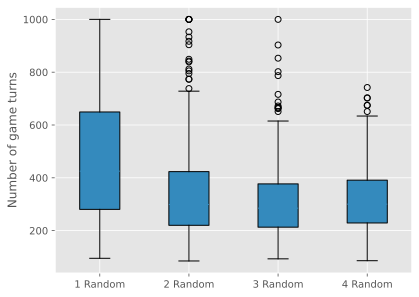

In [55]:
plt.style.use("ggplot")


labels = ["1 Random", "2 Random", "3 Random", "4 Random"]

fig, ax = plt.subplots()
ax.set_ylabel("Number of game turns")

bplot = ax.boxplot(steps_by_player, tick_labels=labels, patch_artist=True)
ax.grid(visible=True)


plt.show()

## MCTS bots

In [61]:
roots = []


def debug_cb(root):
    roots.append(root)


game = Game(
    catan_map=DEFAULT_MAP,
    players=[
        RandomPlayer(color=Color.RED, is_bot=True),
        MCTSBot(
            color=Color.BLUE,
            n_simulations=50,
            # debug=True,
            debug_cb=debug_cb,
        ),
    ],
)
game.play()

<Color.BLUE: 'BLUE'>

In [63]:
from catan.utils.player_stats import player_stats, print_player_stats

print_player_stats(player_stats(game))

[PlayerStats(color=<Color.RED: 'RED'>,
             player_type='RandomPlayer',
             victory_points=2,
             longest_road=3,
             settlements=[12, 34],
             n_settlements=2,
             roads=[(12, 13), (34, 35), (11, 12), (35, 36), (33, 34), (11, 32)],
             n_roads=6,
             cities=[],
             n_cities=0),
 PlayerStats(color=<Color.BLUE: 'BLUE'>,
             player_type='MCTSBot',
             victory_points=10,
             longest_road=8,
             settlements=[43, 40],
             n_settlements=2,
             roads=[(16, 18), (3, 4), (18, 40), (17, 18), (3, 12), (40, 44),
                    (43, 44), (43, 47), (21, 43), (19, 21), (45, 47), (16, 21),
                    (5, 16)],
             n_roads=13,
             cities=[4, 16],
             n_cities=2)]


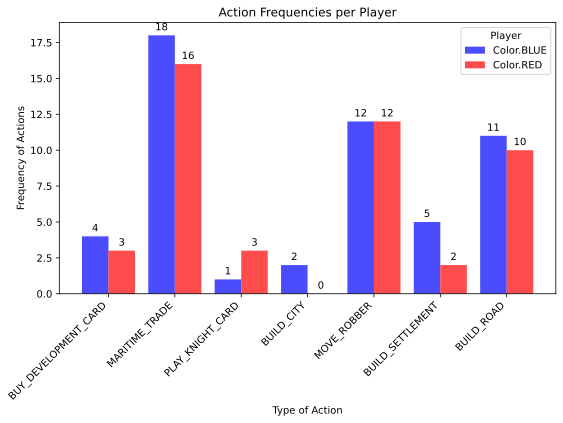

In [184]:
_, _ = plot_action_freqs(
    game.state.actions, exclusions=[ActionType.ROLL.name, ActionType.END_TURN.name]
)

In [233]:
from matplotlib import pyplot as plt
import numpy as np

mcts_color: Color = Color.BLUE
sim_range = np.arange(10, 100, 10)
games_per_sim = 10
n_playouts = len(sim_range)
mcts_win_rates = np.zeros(n_playouts)

for node_id, n_sim in enumerate(sim_range):
    mcts_playout_wins = 0
    for n_game_in_sim in range(1, games_per_sim + 1):
        print(f"MCTS Sims {n_sim} | Playing {n_game_in_sim}/{games_per_sim} game")
        game = Game(
            catan_map=DEFAULT_MAP,
            players=[
                RandomPlayer(color=Color.RED, is_bot=True),
                MCTSBot(color=Color.BLUE, n_simulations=n_sim),
            ],
        )
        winner_color = game.play()

        if winner_color == mcts_color:
            mcts_playout_wins += 1

    mcts_win_rates[node_id] = mcts_playout_wins / games_per_sim

MCTS Sims 10 | Playing 1/10 game


KeyboardInterrupt: 

In [139]:
from catan.core.models.player import Color

mcts_color: Color = Color.BLUE
sim_range2 = np.arange(1, 10, 1)
games_per_sim = 10
n_playouts = len(sim_range2)
mcts_win_rates2 = np.zeros(n_playouts)

for node_id, n_sim in enumerate(sim_range2):
    mcts_playout_wins = 0
    for n_game_in_sim in range(1, games_per_sim + 1):
        print(f"MCTS Sims {n_sim} | Playing {n_game_in_sim}/{games_per_sim} game")
        game = Game(
            catan_map=DEFAULT_MAP,
            players=[
                RandomPlayer(color=Color.RED, is_bot=True),
                MCTSBot(color=mcts_color, n_simulations=n_sim),
            ],
        )
        winner_color = game.play()

        if winner_color == mcts_color:
            mcts_playout_wins += 1

    mcts_win_rates2[node_id] = mcts_playout_wins / games_per_sim

MCTS Sims 1 | Playing 1/10 game
MCTS Sims 1 | Playing 2/10 game
MCTS Sims 1 | Playing 3/10 game
MCTS Sims 1 | Playing 4/10 game
MCTS Sims 1 | Playing 5/10 game
MCTS Sims 1 | Playing 6/10 game
MCTS Sims 1 | Playing 7/10 game
MCTS Sims 1 | Playing 8/10 game
MCTS Sims 1 | Playing 9/10 game
MCTS Sims 1 | Playing 10/10 game
MCTS Sims 2 | Playing 1/10 game
MCTS Sims 2 | Playing 2/10 game
MCTS Sims 2 | Playing 3/10 game
MCTS Sims 2 | Playing 4/10 game
MCTS Sims 2 | Playing 5/10 game
MCTS Sims 2 | Playing 6/10 game
MCTS Sims 2 | Playing 7/10 game
MCTS Sims 2 | Playing 8/10 game
MCTS Sims 2 | Playing 9/10 game
MCTS Sims 2 | Playing 10/10 game
MCTS Sims 3 | Playing 1/10 game
MCTS Sims 3 | Playing 2/10 game
MCTS Sims 3 | Playing 3/10 game
MCTS Sims 3 | Playing 4/10 game
MCTS Sims 3 | Playing 5/10 game
MCTS Sims 3 | Playing 6/10 game
MCTS Sims 3 | Playing 7/10 game
MCTS Sims 3 | Playing 8/10 game
MCTS Sims 3 | Playing 9/10 game
MCTS Sims 3 | Playing 10/10 game
MCTS Sims 4 | Playing 1/10 game
MCTS 

Text(0.02, 0.5, 'MCTS win rate')

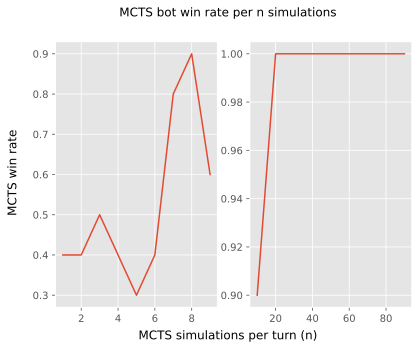

In [174]:
fig, axs = plt.subplots(ncols=2)

fig.suptitle("MCTS bot win rate per n simulations")

axs[1].plot(sim_range, mcts_win_rates)

axs[0].plot(sim_range2, mcts_win_rates2)

fig.supxlabel("MCTS simulations per turn (n)")
fig.supylabel("MCTS win rate")

In [100]:
from catan.utils.player_stats import player_stats, print_player_stats


stats = player_stats(game)
print_player_stats(stats)

[PlayerStats(color=<Color.BLUE: 'BLUE'>,
             player_type='MCTSBot',
             victory_points=10,
             longest_road=8,
             settlements=[0, 43],
             n_settlements=2,
             roads=[(16, 18), (8, 9), (7, 8), (7, 24), (18, 40), (17, 18),
                    (40, 44), (43, 44), (43, 47), (21, 43), (19, 21), (45, 47),
                    (16, 21), (5, 16), (0, 5)],
             n_roads=15,
             cities=[16, 9, 17],
             n_cities=3),
 PlayerStats(color=<Color.RED: 'RED'>,
             player_type='RandomPlayer',
             victory_points=4,
             longest_road=3,
             settlements=[46, 24],
             n_settlements=2,
             roads=[(45, 46), (24, 53), (46, 48), (48, 49)],
             n_roads=4,
             cities=[],
             n_cities=0),
 PlayerStats(color=<Color.ORANGE: 'ORANGE'>,
             player_type='RandomPlayer',
             victory_points=4,
             longest_road=4,
             settlements=

### MCTS Debug

### MCTS optimization

Our current MCTS scheme performance suffers, this is primarily by high branching factor -- actions possible with every step. According to thew previous analysis the average.

#### Potential moves that can be reduced

1. Initial settlement and road building, since there are 54 possible placement, we can limit only to the most promising ones.
2. Thief placement, instead of all possible tiles, place thief only on the most harmful fields for the opponents.
3. Die rolls and turn ends could be fast forwarded, no need to simulate the whole game.
4. 

In [102]:
from catan.analysis.ui import create_game, view_game


game_id = create_game(["RANDOM", "RANDOM", "RANDOM", "MCTS"])
view_game(game_id)

In [103]:
from catan.bots.mcts_bot import MCTSBot

roots = []


def debug_cb(root):
    roots.append(root)


game = Game(
    catan_map=DEFAULT_MAP,
    players=[
        MCTSBot(color=Color.BLUE, n_simulations=30, debug=True, debug_cb=debug_cb),
        RandomPlayer(color=Color.RED, is_bot=True),
        RandomPlayer(color=Color.ORANGE, is_bot=True),
    ],
)
game.state.playable_actions
game.play()

Move 0: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_SETTLEMENT: 'BUILD_SETTLEMENT'>, value=18)
Move 0: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_ROAD: 'BUILD_ROAD'>, value=(16, 18))
Move 4: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_SETTLEMENT: 'BUILD_SETTLEMENT'>, value=20)
Move 4: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_ROAD: 'BUILD_ROAD'>, value=(20, 22))
Move 4: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUY_DEVELOPMENT_CARD: 'BUY_DEVELOPMENT_CARD'>, value=None)
Move 7: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.MOVE_ROBBER: 'MOVE_ROBBER'>, value=((2, -1, -1), <Color.ORANGE: 'ORANGE'>, None))
Move 7: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_ROAD: 'BUILD_ROAD'

<Color.BLUE: 'BLUE'>

<Figure size 1800x1000 with 0 Axes>

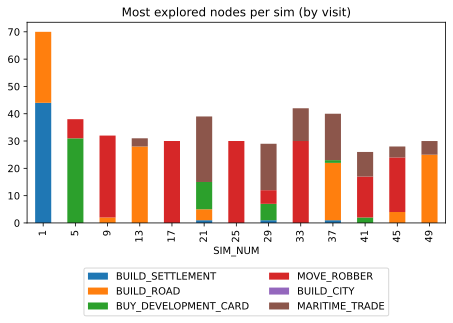

In [97]:
from catan.analysis.mcts_utils import pretty_print_mcts_tree
from catan.analysis.plot_utils import get_mcts_sims_stats
from matplotlib import pyplot as plt

plt.figure(figsize=(18, 10))


stats_df = get_mcts_sims_stats(
    roots,
    [
        ActionType.BUILD_CITY,
        ActionType.BUILD_SETTLEMENT,
        ActionType.BUILD_ROAD,
        ActionType.MARITIME_TRADE,
        ActionType.BUY_DEVELOPMENT_CARD,
        ActionType.MOVE_ROBBER,
    ],
    kind="visit",
)[::4]

ax = stats_df.plot(
    x="SIM_NUM", kind="bar", stacked=True, title="Most explored nodes per sim (by visit)"
)
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2
)
plt.tight_layout()
plt.show()


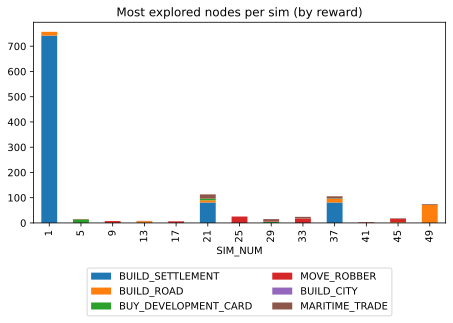

In [96]:
stats_df = get_mcts_sims_stats(
    roots,
    [
        ActionType.BUILD_CITY,
        ActionType.BUILD_SETTLEMENT,
        ActionType.BUILD_ROAD,
        ActionType.MARITIME_TRADE,
        ActionType.BUY_DEVELOPMENT_CARD,
        ActionType.MOVE_ROBBER,
    ],
    kind="reward"
)[::4]

ax = stats_df.plot(
    x="SIM_NUM", kind="bar", stacked=True, title="Most explored nodes per sim (by reward)"
)
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2
)  # ncol controls number of columns in legend
plt.tight_layout()
plt.show()

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Action Frequencies per Player'}, xlabel='Type of Action', ylabel='Frequency of Actions'>)

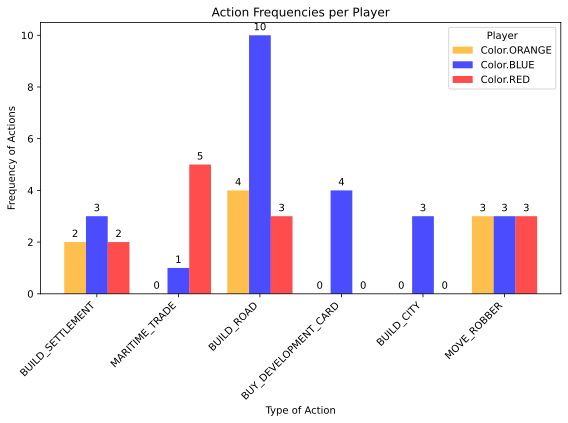

In [106]:
from catan.analysis.plot_utils import plot_action_freqs

plot_action_freqs(
    game.state.actions, exclusions=[ActionType.ROLL.name, ActionType.END_TURN.name]
)

## Catan Bot strategies

1. Balanced
2. Greedy VP hustler
3. Resource Bleeder
4. Title Chaser